In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [4]:
benign=np.array(Dataset_loader(r'/content/gdrive/MyDrive/BreakHis/1 Benign', 320))
malign=np.array(Dataset_loader(r'/content/gdrive/MyDrive/BreakHis/1 Malignant', 320))


100%|██████████| 5437/5437 [01:58<00:00, 45.72it/s]


In [5]:
benign_label=np.zeros(len(benign))
malign_label=np.zeros(len(malign))
print(len(malign_label)+len(benign_label))

7838


In [15]:
x=np.concatenate((malign,benign), axis=0)
y=np.concatenate((malign_label,benign_label), axis=0)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.33, random_state=11)

In [16]:
s=np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train=x_train[s]
y_train=y_train[s]

s=np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test=x_test[s]
y_test=y_test[s]

y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

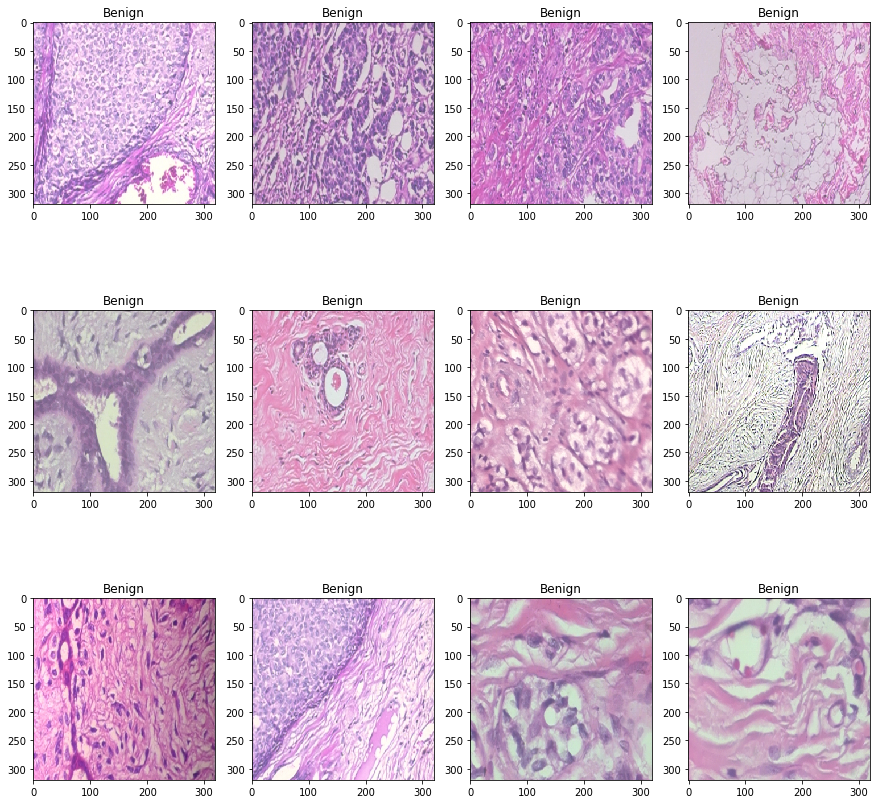

In [17]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [10]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True,  
    )

In [11]:
def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tf.keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding='same')(input_img)
    A1 = tf.keras.layers.ReLU()
    A1=A1(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8),strides=(8,8),padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(1,1),padding='same')(P1)
    A2 = tf.keras.layers.ReLU()
    A2=A2(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=(4,4),padding="same")(A2)
    F = tf.keras.layers.Flatten()(P2)
    outputs =  tf.keras.layers.Dense(units=2, activation='softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [12]:
model=convolutional_model((320,320,3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 320, 8)       392       
_________________________________________________________________
re_lu (ReLU)                 (None, 320, 320, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 16)        528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 40, 40, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0     

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

In [14]:
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test, y_test)
                    )

Epoch 1/20
83/83 [==============================] - 204s 2s/step - loss: 0.2099 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
37/83 [============>.................] - ETA: 1:36 - loss: 0.0000e+00 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [46]:
history.history

{'accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.335670352748576e-38,
  5.321239220643573e-38,
  5.335008939873415e-38,
  5.321900072999349e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38,
  5.321239220643573e-38],
 'val_accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

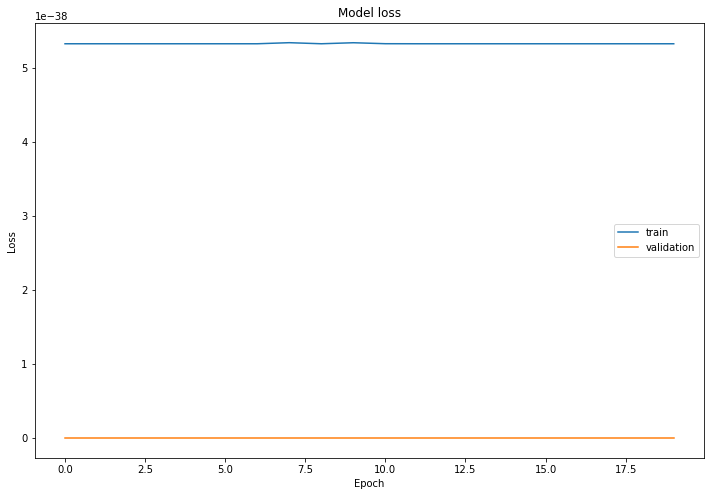

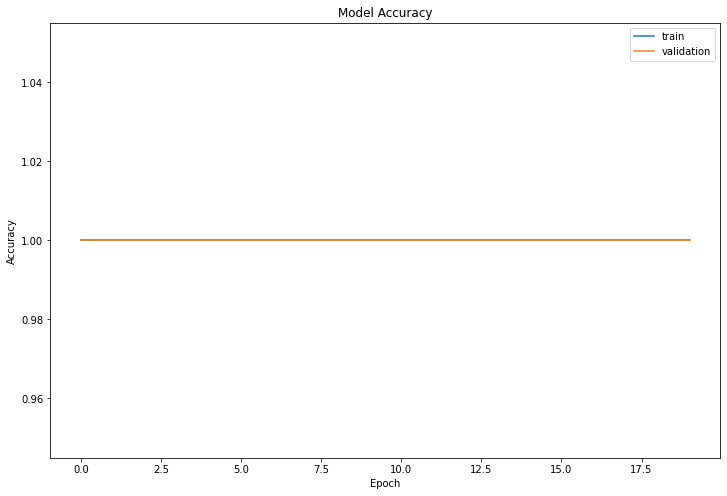

In [47]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [48]:
model.evaluate(x_test,y_test)

81/81 [==============================] - 2s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [49]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

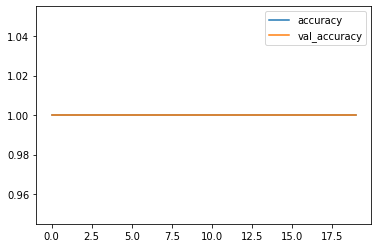

In [51]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

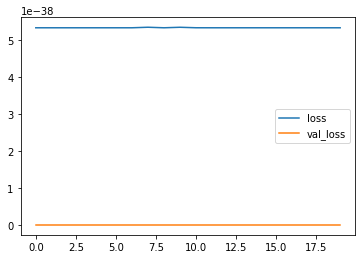

In [52]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [54]:
y_val_pred = model.predict(x_test)

In [55]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_val_pred, axis=1))

1.0

In [56]:
y_pred = model.predict(x_test)

In [57]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(x_test)/16)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [00:48<00:00,  4.82s/it]


Confusion matrix, without normalization
[[2587]]


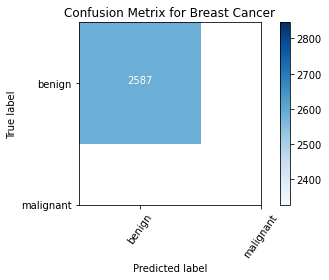

In [59]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')